Report 4

Bryan Werth

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeBinomialPmf, MakeMixture
from thinkbayes2 import EvalWeibullPdf, EvalWeibullCdf, MakeWeibullPmf
from thinkbayes2 import MakeNormalPmf, EvalPoissonPmf,MakePoissonPmf
import thinkplot

In [2]:
def SampleWeibull(lam, k, n=1):
    return np.random.weibull(k, size=n) * lam

**Exercise:** Write a class called `LightBulb` that inherits from `Suite` and `Joint` and provides a `Likelihood` function that takes an observed lifespan as data and a tuple, `(lam, k)`, as a hypothesis.  It should return a likelihood proportional to the probability of the observed lifespan in a Weibull distribution with the given parameters.

Test your method by creating a `LightBulb` object with an appropriate prior and update it with a random sample from a Weibull distribution.

Plot the posterior distributions of `lam` and `k`.  As the sample size increases, does the posterior distribution converge on the values of `lam` and `k` used to generate the sample?

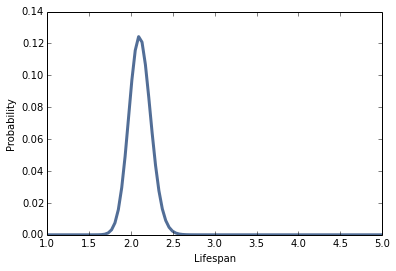

In [3]:
from itertools import product

class LightBulb(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        #data is observed lifespan
        #hypothesis is the lam value and the k value in a tuple
        lamLightbulb, kLightbulb = hypo
        xLightbulb = data
        if lamLightbulb == 0:
            return 0
        return EvalWeibullPdf(xLightbulb,lamLightbulb,kLightbulb)
    
lamRange = np.linspace(1,5,100)
kRange = np.linspace(1,5,100)
Lightbulbs = LightBulb(product(lamRange,kRange))
data = SampleWeibull(2,1.5,100)
Lightbulbs.UpdateSet(data)
lamDistribution = Lightbulbs.Marginal(0)
thinkplot.Pdf(lamDistribution)
thinkplot.Config(xlabel='Lifespan',ylabel='Probability')

For this problem, we are inheriting from both Suite and Joint. We are inheriting from Joint because the prior distribution involves two values (lam and k). The only thing that needs to be changed is the likelihood function, so we redefine that. First, the data is a tuple made up of lam and k, so we unpack that. After, we redefine the data as the observed lifespan for clarity sake. If the lambda value is 0, then the returned probability should be 0. Otherwise, we want to calculate the probability of the observed lifespan given the lambda and k values. We do this by using the EvalWeibullPdf with the inputted parameters. To test this we define a reasonable range of lambda and k values for the prior. We define a lightbulb class using this prior. We then produce a random reasonable lightbulb lifespan using a reasonable lambda and k value. Then we extract the lambda distribution from the joint distribution using the marginal method. Finally, we plot the lambda distribution as seen.

**Exercise:** Now suppose that instead of observing a lifespan, `k`, you observe a lightbulb that has operated for 1 year and is still working.  Write another version of `LightBulb` that takes data in this form and performs an update. 

In [4]:
class LightBulb(Suite,Joint):

    def Likelihood(self, data, hypo):
        #
        lam, k = hypo
        x = data
        if(lam == 0):
            return 0
        return 1-EvalWeibullCdf(x, lam, k)

For this problem, we unpack the variables as done in the previous problem. We account for the same basecase (lambda equals zero). If lambda does not equal zero, we subtract the probability that the lightbulb is dead from 1 to get the probability that the lightbulb is still working. We then return this as the result. 

**Exercise:** Suppose you install a light bulb and then you don't check on it for a year, but when you come back, you find that it has burned out.  Extend `LightBulb` to handle this kind of data, too.

In [5]:
class LightBulbWithFlag(Suite,Joint):
    
    def Likelihood(self,data,hypo):
        lam, k = hypo
        flag, x = data
        if(lam==0):
            return 0
        if(flag=='eq'):
            return EvalWeibullPdf(x,lam,k)
        elif(flag=='gt'):
            return 1-EvalWeibullCdf(x,lam,k)
        else:
            return EvalWeibullCdf(x,lam,k)

For this problem, we are using a flag which is set to one of three potential options. If the flag is set to 'eq', then x is the actual lifespan of the lightbulb. If the flag is set to 'gt', then x is the lowerbound of the lightbulb lifespan, meaning the lightbulb is still working. Otherwise, if the flag is set to 'lt', then x is the upperbound of the lightbulb lifespan, meaning the lightbulb is not working and x is greater than the lifespan. We unpack the data and hypothesis and check the base-case as always. Then, we check for each flag option. If the flag is 'eq', then the probability of this case is computed by finding the pdf given the known values. If the flag is 'gt', then the probablility of this case is computed the same way as the previous problem, by subtracting the probability of the lightbulb dying from 1 to get the probability that it is still working. If the flag is 'lt', then the probability of this case is computed by finding the weibull cdf, the probability of the lightbulb being dead already. 

**Exercise:** Suppose we know that, for a particular kind of lightbulb in a particular location, the distribution of lifespans is well modeled by a Weibull distribution with `lam=2` and `k=1.5`.  If we install `n=100` lightbulbs and come back one year later, what is the distribution of `c`, the number of lightbulbs that have burned out?

29.781149867343341

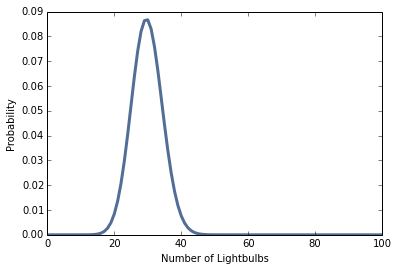

In [7]:
lam = 2
k = 1.5
n = 100
LightsDeadProbability = EvalWeibullCdf(1,lam,k)
LightPmf = MakeBinomialPmf(n,LightsDeadProbability)
thinkplot.Pdf(LightPmf)
thinkplot.Config(xlabel='Number of Lightbulbs',ylabel='Probability')
LightPmf.Mean()

For this problem, we are given lambda and k values along with a number of lightbulbs. First, we calculate the probability of one lightbulb being burned out after a year. Then, we produce a binomial pmf to represent the distribution of the number of burned out lights given the probability calculated by taking the weibull cdf. Finally we plot. As can be found by taking the mean of the pmf, it is most likely that around 30 lightbulbs are burned out.  

**Exercise:** Now suppose that `lam` and `k` are not known precisely, but we have a `LightBulb` object that represents the joint posterior distribution of the parameters after seeing some data.  Compute the posterior predictive distribution for `c`, the number of bulbs burned out after one year.

0.099247206902248794

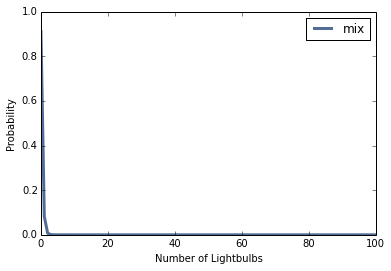

In [9]:
lamRange = np.linspace(1,5,100)
kRange = np.linspace(1,5,100)
LightbulbsPrior = LightBulb(product(lamRange,kRange))
data = SampleWeibull(2,1.5,100)
LightbulbsPrior.UpdateSet(data)

metapmf = Pmf()
for (lam,k), prob in LightbulbsPrior.Items():
    p = EvalWeibullCdf(1,lam,k)
    pmf = MakeBinomialPmf(100,p)
    metapmf[pmf] = prob
    
Lightbulbmixture = MakeMixture(metapmf)
thinkplot.Pdf(Lightbulbmixture)
thinkplot.Config(xlabel='Number of Lightbulbs',ylabel='Probability')
Lightbulbmixture.Mean()

For this problem, we need to first do what we did in the first problem: define a prior for a LightBulb suite and update it with some data. Using this updated pmf, we create a mixture of the distributions of the different lambda and k combinations. The distributions are computed as they were in the previous problem. First, a metapmf combination of the distributions is computed. Following this, an actual mixture is produced using the MakeMixture function. Finally we plot and compute the mean number of lightbulbs. For this case, the probable number of broken lightbulbs is 30 still.